# Face Mask classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize whether a person wear a mask on his face or not.  
Furthermore, the system needs to recognize whether a person is young or old.  

This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Download data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip Data

In [ ]:
!unzip -q "/content/drive/My Drive/Dataset_Faces/data.zip"
print("Data is unzipped")

Data is unzipped


# Read data

* (train/test/valid)_files : list of image directory locations in folder
* (train/test/valid)_targets : one-hot encoding based on folder names
* class_names : list of folder names

In [ ]:
from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    mask_files = np.array(data['filenames'])
    mask_targets = np_utils.to_categorical(np.array(data['target']), 4)
    class_names = data['target_names']
    return mask_files, mask_targets, class_names

# load train, test, and validation datasets
train_files, train_targets, class_names = load_dataset('data/train')
valid_files, valid_targets, _ = load_dataset('data/val')
test_files, test_targets, _ = load_dataset('data/test')

Using TensorFlow backend.


In [ ]:
print(train_targets.shape)
print(valid_targets.shape)
print(test_targets.shape)

(2354, 4)
(292, 4)
(298, 4)


# Implement load_image method

* Read Image
* Preprocess Image
  * Resize
  * Preprocess_input

In [ ]:
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input

def load_image(path):
  image = cv2.imread(path).astype(np.float32)
  image_resized = cv2.resize(image,(224,224))
  image = preprocess_input(image_resized)
  return image

def load_dataset(files):
  for i, file in enumerate(files):
    vector = []
    for file in files:
      vector.append(load_image(file))
    return np.array(vector)


train_X = load_dataset(train_files)
test_X = load_dataset(test_files)
val_test_X = load_dataset(valid_files)


In [ ]:
print(train_X.shape)
print(test_X.shape)
print(val_test_X.shape)

(2354, 224, 224, 3)
(298, 224, 224, 3)
(292, 224, 224, 3)


# Visualization of preprocess Data 

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,20))

rows = 10
columns = 2
for i in range(20): 
  
    ax1 = fig.add_subplot(rows, columns,(i+1)) 
  
    ax1.imshow(train_X[i], cmap='gray')

    title = ("Class: ") + class_names[np.argmax(train_targets[i])]
    ax1.text(0, -2, title, size=20)


plt.show()

# Model architecture

In [ ]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

model = DenseNet169(include_top=False, input_shape=(224,224,3), weights='imagenet')
flat_ = GlobalAveragePooling2D()(model.output)
class_ = Dense(1000, activation='relu')(flat_)
outputs = Dense(4, activation='softmax')(class_)

model = Model(inputs=model.inputs, outputs=outputs)

51879936/51877672 [==============================] - 2s 0us/step


#Model Summery

In [ ]:
model.summary()

# Compile model

In [ ]:
import keras
optimzer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

# Train model

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(train_X, train_targets, batch_size=32, epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(val_test_X, 
                                     valid_targets))

# Load Best Model

In [ ]:
from keras.models import load_model

model = load_model('best_model.pt')

# Evaluate Model

In [ ]:
score = model.evaluate(test_X, test_targets)

print('Test accuracy: ', score[1])

298/298 [==============================] - 7s 22ms/step
Test accuracy:  0.9697986841201782


In [ ]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names[predicted_class]

In [ ]:
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # PREPROCESS INPUT
  image_resized  = cv2.resize(image, (224,224))
  image_preprocessed  = preprocess_input(image_resized)
  return image_preprocessed, image_

def predict_url(url):
  image_preprocessed, image = url_to_image(url)
  predicted_class = get_prediction(image_preprocessed)
  plt.imshow(image)
  plt.title("Predicted : " + predicted_class)

#  Produced outputs :

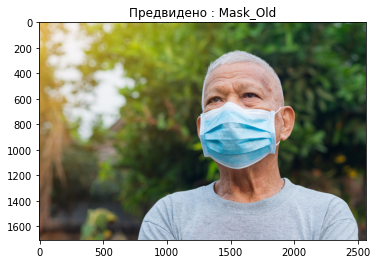

In [ ]:
predict_url("https://i1.wp.com/www.studyfinds.org/wp-content/uploads/2020/06/AdobeStock_336882040-scaled.jpeg?fit=2560%2C1707&ssl=1")

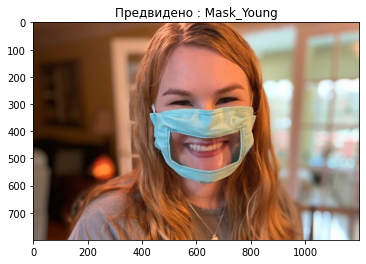

In [ ]:
predict_url("https://s.yimg.com/uu/api/res/1.2/XV8Osw7ND6JJDFsWMMp4SA--~B/aD04MDA7dz0xMjAwO3NtPTE7YXBwaWQ9eXRhY2h5b24-/https://media.zenfs.com/en/hello_giggles_454/13a4dc4992bed56fa85581e38b5eac17")

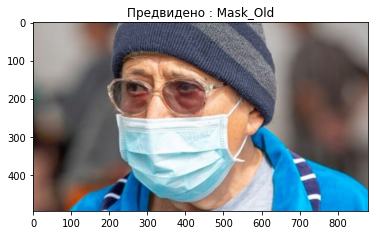

In [ ]:
predict_url('https://cdn.jns.org/uploads/2020/03/Elderly-in-Israel-and-the-Coronavirus-1-880x495.jpg')

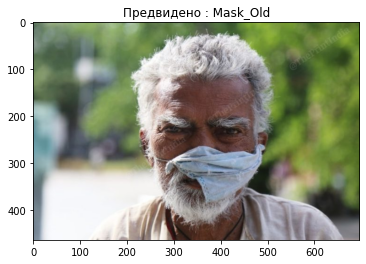

In [ ]:
predict_url('https://d2c7ipcroan06u.cloudfront.net/wp-content/uploads/2020/04/Old-man-696x464.jpg')

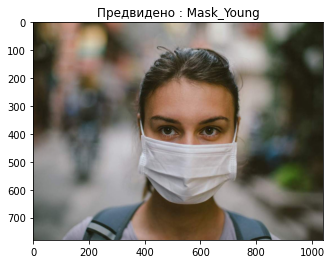

In [ ]:
predict_url("https://i2.wp.com/static.toiimg.com/photo/msid-74491757/74491757.jpg?w=1040&ssl=1")

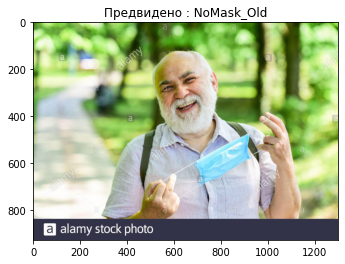

In [ ]:
predict_url('https://c8.alamy.com/comp/2C2HHW1/senior-man-take-off-medical-mask-old-man-walking-in-park-life-during-coronavirus-lockdown-enjoy-the-beauty-fear-of-illness-strategy-in-battling-virus-prohibition-on-visiting-public-places-2C2HHW1.jpg')

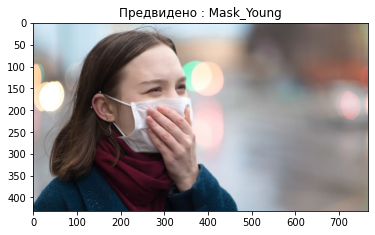

In [ ]:
predict_url('https://cdn.shrm.org/image/upload/c_crop,h_1193,w_2121,x_0,y_25/c_fit,f_auto,q_auto,w_767/v1/News/iStock-1202284625_jgnxki?databtoa=eyIxNng5Ijp7IngiOjAsInkiOjI1LCJ4MiI6MjEyMSwieTIiOjEyMTgsInciOjIxMjEsImgiOjExOTN9fQ%3D%3D')

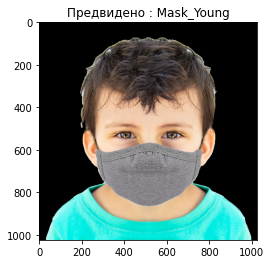

In [ ]:
predict_url('https://cdn.shopify.com/s/files/1/0273/3847/3559/products/DMS-KIDS-MASK-MOCKUP-GREY_1024x.png?v=1588816252')

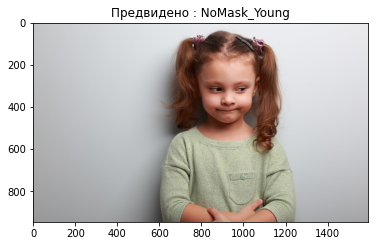

In [ ]:
predict_url('https://cms-tc.pbskids.org/parents/expert-tips-and-advice/how-to-teach-frustration-tolerance-to-kids-hero.jpg?mtime=20181008030129')

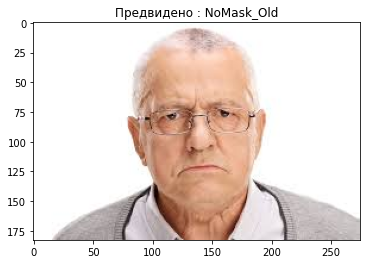

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQkL-a3YKFLsQL1nA1oovhITNAXnIslW9dLBw&usqp=CAU')

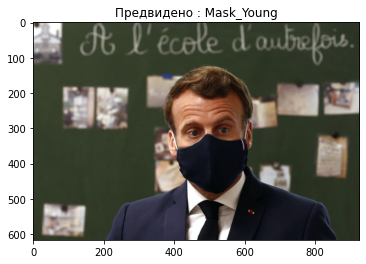

In [ ]:
predict_url("https://images.theconversation.com/files/332693/original/file-20200505-83757-13a6ydy.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=926&fit=clip")

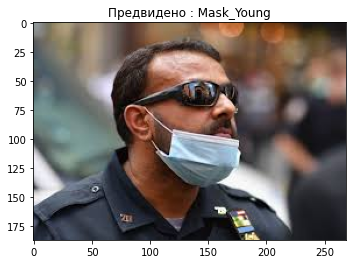

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQONIDkIf6HwuIUCs-Pd2tGuLcuQa6LcVqh3g&usqp=CAU")

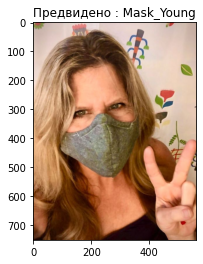

In [ ]:
predict_url("https://smartcdn.prod.postmedia.digital/tillsonburgnews/wp-content/uploads/2020/04/TN.TN0408spencer.jpg?quality=80")

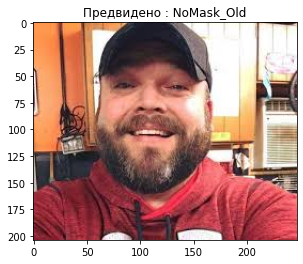

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSzy0HLRmJ-6KjoXUdxiPEZ9ygx--4Or4UMPA&usqp=CAU")

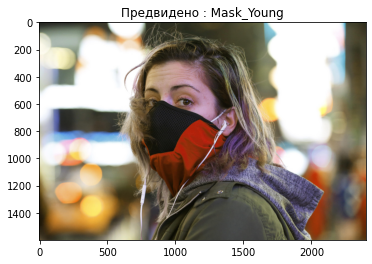

In [ ]:
predict_url("https://www.wvxu.org/sites/wvxu/files/styles/x_large/public/202004/AP_20073116772407.jpg")

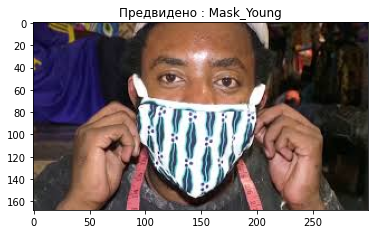

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSwBhLHJc46t8diNIQqp5_TaNHQd6UHRDGkeg&usqp=CAU")

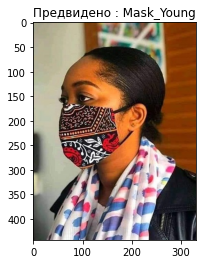

In [ ]:
predict_url("https://www.tanzaniaschoolfoundation.org/wp-content/uploads/2020/04/IMG-20200404-WA0002.jpg")

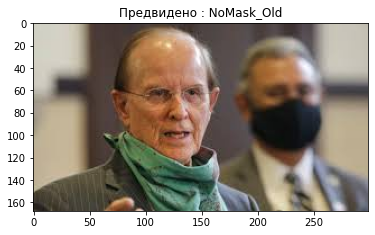

In [ ]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSUwDS8WJKeGXcjF3Ifj58P9FuoBTzSh4W-sg&usqp=CAU")

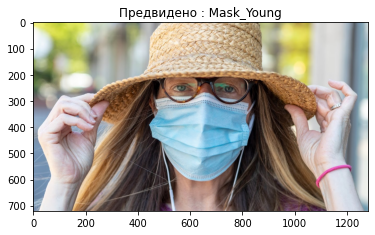

In [ ]:
predict_url("https://i.ytimg.com/vi/yC07bf_iTZo/maxresdefault.jpg")

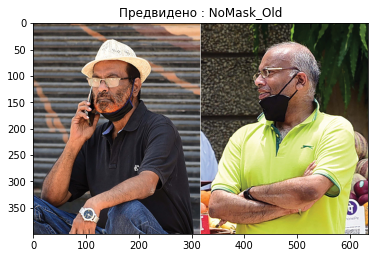

In [ ]:
predict_url("https://static.toiimg.com/img/76176408/Master.jpg")

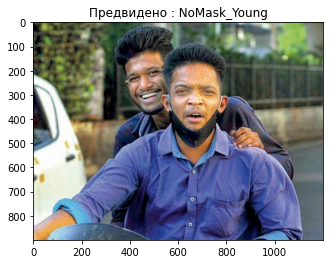

In [ ]:
predict_url("https://static.toiimg.com/photo/msid-76199934/76199934.jpg?resizemode=4&width=400")

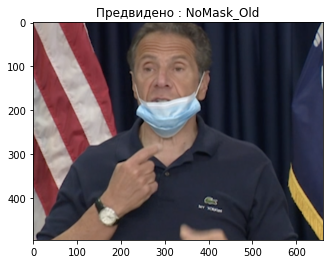

In [ ]:
predict_url("https://cms.prod.nypr.digital/images/306890/fill-661x496/")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

scores = model.evaluate(test_X, test_targets, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))

y_pred = model.predict(test_X)
print(classification_report(y_pred.round(), test_targets))

accuracy = accuracy_score(test_targets, y_pred.round(), normalize=True)
f1score = f1_score(test_targets, y_pred.round(), average='weighted')

Accuracy: 96.98%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.95      0.96      0.95        77
           2       0.97      0.99      0.98        72
           3       0.99      0.99      0.99        77

   micro avg       0.97      0.97      0.97       297
   macro avg       0.97      0.97      0.97       297
weighted avg       0.97      0.97      0.97       297
 samples avg       0.97      0.97      0.97       297



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
